In [58]:
import os.path
import glob
import torch
from torch_geometric.loader import DataLoader
from pointcloud_dataloader import PointCloudsInFiles
from matplotlib import pyplot as plt
import sklearn.metrics as metrics
from math import sqrt
from pointcloud_dataloader import read_las
import pandas as pd
import itertools
from itertools import compress
from pathlib import Path
from random import sample
import numpy as np

# Apply the model to the test dataset and plot the results --------------------------------------------------

# Select a model to use:
model_file = None

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Specify model params
use_columns = ['intensity_normalized']
use_datasets = ["BC", "RM", "PF"]  # Possible datasets: BC, RM, PF
num_points = 1_000
test_dataset_path = r'D:\Sync\Data\Model_Input\test'

# Load most recent model
if model_file is None:
    folder_path = r'D:\Sync\DL_Development\Models'
    file_type = r'\*.model'
    files = glob.glob(folder_path + file_type)
    model_file = max(files, key=os.path.getctime)
    model = torch.load(model_file)
else:
    model = torch.load(model_file)
print("Using model:", model_file)

# Get test data
test_dataset = PointCloudsInFiles(test_dataset_path, '*.las', max_points=num_points, use_columns=use_columns,
                                  filter_height=0.2, dataset=use_datasets)

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)

Using model: D:\Sync\DL_Development\Models\DL_model_2022_07_25_09_10_28.model


In [70]:
# Apply the model
model.eval()
for idx, data in enumerate(test_loader):
    data = data.to(device)
    pred = torch.reshape(model(data), (len(data.y), 1)).to('cpu').detach().numpy()
    obs = torch.reshape(data.y, (len(data.y), 1)).to('cpu').detach().numpy()
    PlotID = data.PlotID

#Reshape for bark, branch, foliage, wood columns
obs_arr = np.reshape(a=obs, newshape=(len(obs)//4, 4))
pred_arr = np.reshape(a=pred, newshape=(len(obs)//4, 4))
#Join arrays
arr = arr = np.concatenate((obs_arr, pred_arr), axis=1)
#Convert to data frame
df = pd.DataFrame(arr,
             columns=['bark_obs', 'branch_obs', 'foliage_obs', 'wood_obs',
                      'bark_pred', 'branch_pred', 'foliage_pred', 'wood_pred'],
                  index=PlotID)

#Add observed/predicted total biomass columns to df
df["total_agb_obs"] = df["bark_obs"] + df["branch_obs"] + df["foliage_obs"] + df["wood_obs"]
df["total_agb_pred"] = df["bark_pred"] + df["branch_pred"] + df["foliage_pred"] + df["wood_pred"]

#Create a data frame to store component metrics
metrics_df = pd.DataFrame(columns=["r2", "rmse", "mape"], index= ["wood", "bark", "branch", "foliage", "total_agb"])

#Loop through each biomass component get model performance metrics
for comp in metrics_df.index.tolist():
    metrics_df.loc[comp, "r2"] = round(metrics.r2_score(df[f"{comp}_obs"], df[f"{comp}_pred"]), 2)
    metrics_df.loc[comp, "rmse"] = round(sqrt(metrics.mean_squared_error(df[f"{comp}_obs"], df[f"{comp}_pred"])), 2)
    metrics_df.loc[comp, "mape"] = round(metrics.mean_absolute_percentage_error(df[f"{comp}_obs"], df[f"{comp}_pred"]), 1)

print(metrics_df)


             r2   rmse mape
wood      -0.66   8.57  1.7
bark       0.19   0.76  1.4
branch     0.11   1.12  1.3
foliage    0.27    0.5  1.0
total_agb -0.35  10.35  0.9


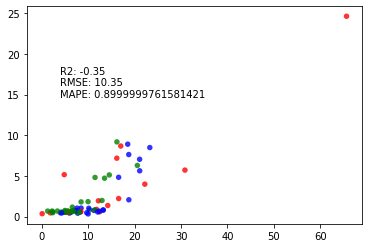

0.9

In [73]:
#Add dataset col
df["dataset"] = "blank"

#Add a column to df for dataset
for id in  df.index.tolist():
    df.loc[id, "dataset"] = id[0:2]

#Add color for each dataset
df["colour"] = "green"
df.loc[df["dataset"] == "BC", "colour"] = "red"
df.loc[df["dataset"] == "PF", "colour"] = "blue"

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df["total_agb_obs"], df["total_agb_pred"],
           alpha=0.8, c=df["colour"], edgecolors='none', s=30,
           label=df["dataset"])

plt.figtext(0.1, 0.65, f"R2: {metrics_df.loc['total_agb', 'r2']}\nRMSE: {metrics_df.loc['total_agb', 'rmse']}\nMAPE: {metrics_df.loc['total_agb', 'mape']}",
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes)
plt.show()

metrics_df.loc['total_agb', 'mape']


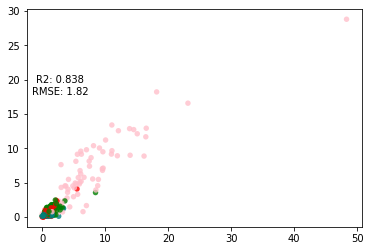

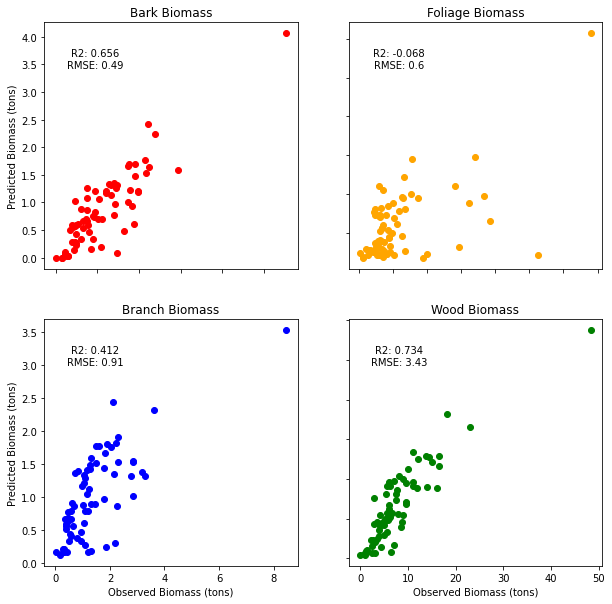

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#Bark
ax[0, 0].scatter(df["bark_obs"], df["bark_pred"], color="red")
plt.figtext(0.2, 0.85, f"R2: {bark_r2}\nRMSE: {bark_rmse}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax[0, 0].transAxes)


#Branch
ax[1, 0].scatter(df["branch_obs"], df["branch_pred"], color="blue")
plt.figtext(0.2, 0.85, f"R2: {branch_r2}\nRMSE: {branch_rmse}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax[1, 0].transAxes)


#Foliage
ax[0, 1].scatter(df["foliage_obs"], df["foliage_pred"], color="orange")
plt.figtext(0.2, 0.85, f"R2: {foliage_r2}\nRMSE: {foliage_rmse}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax[0, 1].transAxes)


#Wood
ax[1, 1].scatter(df["wood_obs"], df["wood_pred"], color="green")
plt.figtext(0.2, 0.85, f"R2: {wood_r2}\nRMSE: {wood_rmse}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax[1, 1].transAxes)


#Add titles
ax[0, 0].title.set_text('Bark Biomass')
ax[1, 0].title.set_text('Branch Biomass')
ax[0, 1].title.set_text('Foliage Biomass')
ax[1, 1].title.set_text('Wood Biomass')

#Add axis labels
for axis in ax.flat:
    axis.set(xlabel='Observed Biomass (tons)', ylabel='Predicted Biomass (tons)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axis in ax.flat:
    axis.label_outer()

plt.show()

In [ ]:
# Plot residuals


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)
plt.show()

#Add code to export pred vs obs values as csv
